### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [ ]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (5, 5) 
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [ ]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/home/haonans/software/caffe-video_triplet/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [ ]:
caffe.set_mode_gpu()

model_def = '/home/haonans/software/caffe-video_triplet/rank_scripts/rank_alexnet/unsup_net_deploy.prototxt'
model_weights = '/home/haonans/capstone/video_models/unsup_alexnet/video_margin_01_iter_28000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

- Examine the network structure

In [ ]:
# set the size of the input (we can skip this if we're happy
# with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

In [ ]:
# no transformation
image = Image.open('/home/haonans/training/data/qi_xing_piao_chong_0001-0fjQy.png')
plt.imshow(image)

In [ ]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = image

output = net.forward()

print output['fc7'].shape
fc7_features = output['fc7'][0]

### 3. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [15]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 1024)


In [16]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(1024, 4096) (1024,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [17]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

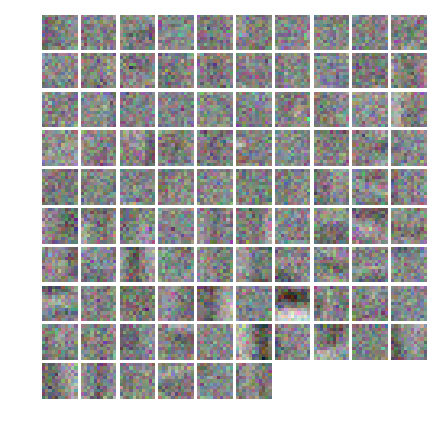

In [18]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

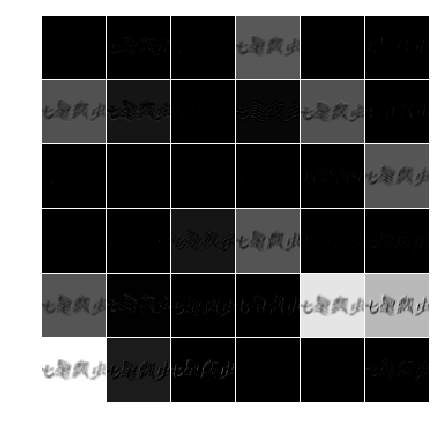

In [19]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

* The fifth layer after pooling, `pool5`

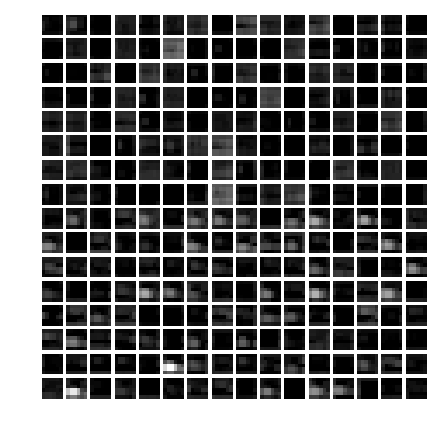

In [20]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

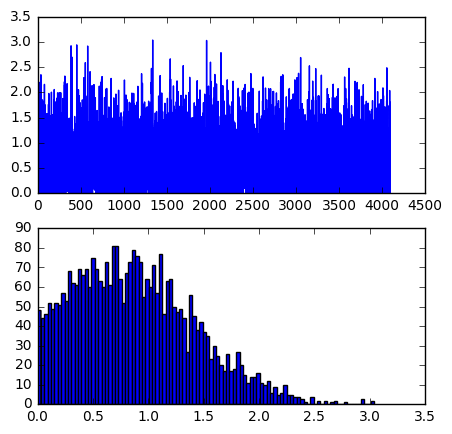

In [21]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The 2nd fully connected layer, `fc7`

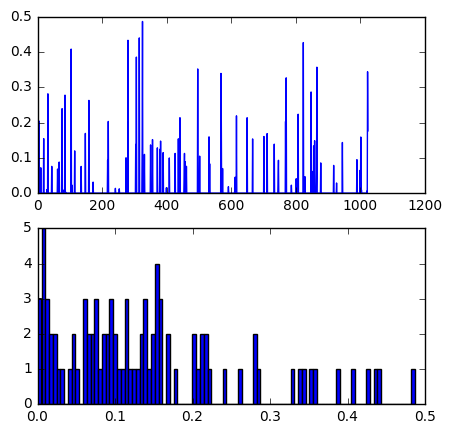

In [22]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)